In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import xlens
import astropy.table as astTable

In [40]:
def compute_shape(catalog):
    e1 = data["e1"] * data["wsel"]
    e2 = data["e2"] * data["wsel"]
    r1 = data["de1_dg1"] * data["wsel"] + data["dwsel_dg1"] * data["e1"]
    r2 = data["de2_dg2"] * data["wsel"] + data["dwsel_dg2"] * data["e2"]
    return e1, e2, r1, r2

def compute_e_psf_2(catalog, e1, e2, r1, r2):
    nbins = 5
    psf_mxx = catalog["i_hsmpsfmoments_shape11"]
    psf_myy = catalog["i_hsmpsfmoments_shape22"]
    psf_mxy = catalog["i_hsmpsfmoments_shape12"]

    e1_psf = (psf_mxx - psf_myy) / (psf_mxx + psf_myy)
    e2_psf = psf_mxy / (psf_mxx + psf_myy) * 2.0

    bins = np.linspace(-0.06, 0.06, nbins + 1)
    bc = 0.5 * (bins[:-1] + bins[1:])
    nom1 = np.histogram(e1_psf, weights=e1, bins=bins)[0]
    denom1 = np.histogram(e1_psf, weights=r1, bins=bins)[0]
    nom2 = np.histogram(e2_psf, weights=e2, bins=bins)[0]
    denom2 = np.histogram(e2_psf, weights=r2, bins=bins)[0]
    return np.stack([bc, nom1, denom1, nom2, denom2])


def compute_e_psf_4(catalog, e1, e2, r1, r2):
    nbins = 5
    e1_psf4 = (
        catalog["i_higherordermomentspsf_40"] -
        catalog["i_higherordermomentspsf_04"]
    )
    e2_psf4 = 2.0 * (
        catalog["i_higherordermomentspsf_31"] +
        catalog["i_higherordermomentspsf_13"]
    )

    bins = np.linspace(-0.02, 0.02, nbins + 1)
    bc = 0.5 * (bins[:-1] + bins[1:])
    nom3 = np.histogram(e1_psf4, weights=e1, bins=bins)[0]
    denom3 = np.histogram(e1_psf4, weights=r1, bins=bins)[0]
    nom4 = np.histogram(e2_psf4, weights=e2, bins=bins)[0]
    denom4 = np.histogram(e2_psf4, weights=r2, bins=bins)[0]
    return np.stack([bc, nom3, denom3, nom4, denom4])


def compute_size(catalog, e1, e2, r1, r2):
    nbins = 5
    psf_mxx = catalog["i_hsmpsfmoments_shape11"] 
    psf_myy = catalog["i_hsmpsfmoments_shape22"] 
    psf_mxy = catalog["i_hsmpsfmoments_shape12"] 
    size_val = 2.355 * (psf_mxx * psf_myy - psf_mxy**2)**0.25

    bins = np.linspace(0.5, 0.7, nbins + 1)
    bc = 0.5 * (bins[:-1] + bins[1:])
    nom5 = np.histogram(size_val, weights=e1, bins=bins)[0]
    denom5 = np.histogram(size_val, weights=r1, bins=bins)[0]
    nom6 = np.histogram(size_val, weights=e2, bins=bins)[0]
    denom6 = np.histogram(size_val, weights=r2, bins=bins)[0]
    return np.stack([bc, nom5, denom5, nom6, denom6])


def compute_variance(catalog, e1, e2, r1, r2):
    nbins = 5
    var_val = catalog["i_variance_value"]
    bins = np.linspace(0.002, 0.007, nbins + 1)
    var = 0.5 * (bins[:-1] + bins[1:])
    nom7 = np.histogram(var_val, weights=e1, bins=bins)[0]
    denom7 = np.histogram(var_val, weights=r1, bins=bins)[0]
    nom8 = np.histogram(var_val, weights=e2, bins=bins)[0]
    denom8 = np.histogram(var_val, weights=r2, bins=bins)[0]
    return np.stack([var, nom7, denom7, nom8, denom8])
    
def compute_color(color, e1, e2, r1, r2, ctype="gr"):
    nbins = 5
    if ctype=="gr":
        cmin = -0.5
        cmax = 2.0
    elif ctype=="ri":
        cmin = -0.2
        cmax = 2.0
    elif ctype=="iz":
        cmin = -1.0
        cmax = 1.0
    elif ctype=="zy":
        cmin = -1.5
        cmax = 1.5
    bins = np.linspace(cmin, cmax, nbins + 1)
    var = 0.5 * (bins[:-1] + bins[1:])
    nom7 = np.histogram(color, weights=e1, bins=bins)[0]
    denom7 = np.histogram(color, weights=r1, bins=bins)[0]
    nom8 = np.histogram(color, weights=e2, bins=bins)[0]
    denom8 = np.histogram(color, weights=r2, bins=bins)[0]
    return np.stack([var, nom7, denom7, nom8, denom8])

In [3]:
ep2 = np.zeros((5, 5))
ep4 = np.zeros((5, 5))
var = np.zeros((5, 5))
size = np.zeros((5, 5))

field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    print(field)
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/fields/{field}.fits"
    data = fitsio.read(fname, columns=["e1", "e2", "de1_dg1", "de2_dg2", "wsel", "dwsel_dg1", "dwsel_dg2", "flux"])
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_color/fields/{field}.fits"
    data2 = fitsio.read(fname, columns=["i_hsmpsfmoments_shape11", "i_hsmpsfmoments_shape12", "i_hsmpsfmoments_shape22", "i_higherordermomentspsf_40", "i_higherordermomentspsf_04", "i_higherordermomentspsf_13", "i_higherordermomentspsf_31", "i_variance_value"])
    mag = 27.0 - 2.5 * np.log10(data["flux"])
    abse2 = data["e1"] ** 2.0 + data["e2"] ** 2.0
    mask = (
        (mag < 25.0) &
        (abse2 < 0.09)
    )
    data = data[mask]
    data2 = data2[mask]
    e1, e2, r1, r2 = compute_shape(data)
    ep2 = ep2 + compute_e_psf_2(data2, e1, e2, r1, r2)
    ep4 = ep4 + compute_e_psf_4(data2, e1, e2, r1, r2)
    var = var + compute_variance(data2, e1, e2, r1, r2)
    size= size + compute_size(data2, e1, e2, r1, r2)
    del data, data2, mask, e1, e2, r1, r2

spring1
spring2
spring3
autumn1
autumn2
hectomap


In [43]:
gr = np.zeros((5, 5))
ri = np.zeros((5, 5))
iz = np.zeros((5, 5))
zy = np.zeros((5, 5))

field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
for field in field_list:
    print(field)
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/fields/{field}.fits"
    data = fitsio.read(fname, columns=["e1", "e2", "de1_dg1", "de2_dg2", "wsel", "dwsel_dg1", "dwsel_dg2", "g_flux", "r_flux", "i_flux", "z_flux", "y_flux", "flux"])
    mag = 27.0 - 2.5 * np.log10(data["flux"])
    abse2 = data["e1"] ** 2.0 + data["e2"] ** 2.0
    mask = (
        (mag < 25.0) &
        (abse2 < 0.09)
    )
    data = data[mask]
    g = 27.0 - 2.5 * np.log10(data["g_flux"])
    r = 27.0 - 2.5 * np.log10(data["r_flux"])
    i = 27.0 - 2.5 * np.log10(data["i_flux"])
    z = 27.0 - 2.5 * np.log10(data["z_flux"])
    y = 27.0 - 2.5 * np.log10(data["y_flux"])
    e1, e2, r1, r2 = compute_shape(data)
    gr = gr + compute_color(g-r, e1, e2, r1, r2, ctype="gr")
    ri = ri + compute_color(r-i, e1, e2, r1, r2, ctype="ri")
    iz = iz + compute_color(i-z, e1, e2, r1, r2, ctype="iz")
    zy= zy + compute_color(z-y, e1, e2, r1, r2, ctype="zy")
    del data, mask, e1, e2, r1, r2

spring1


/tmp/ipykernel_16699/3664388352.py:18: RuntimeWarning: invalid value encountered in log10
  g = 27.0 - 2.5 * np.log10(data["g_flux"])
/tmp/ipykernel_16699/3664388352.py:19: RuntimeWarning: invalid value encountered in log10
  r = 27.0 - 2.5 * np.log10(data["r_flux"])
/tmp/ipykernel_16699/3664388352.py:21: RuntimeWarning: invalid value encountered in log10
  z = 27.0 - 2.5 * np.log10(data["z_flux"])
/tmp/ipykernel_16699/3664388352.py:22: RuntimeWarning: invalid value encountered in log10
  y = 27.0 - 2.5 * np.log10(data["y_flux"])


spring2
spring3
autumn1
autumn2
hectomap


In [61]:
from numpy.lib import recfunctions as rfn

field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
dall = []
for field in field_list:
    print(field)
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/fields/{field}.fits"
    data = fitsio.read(fname, columns=["e1", "e2", "de1_dg1", "de2_dg2", "wsel", "dwsel_dg1", "dwsel_dg2", "flux", "dflux_dg1", "dflux_dg2"])
    dall.append(data)
    del data
dall = rfn.stack_arrays(dall, usemask=False, asrecarray=False)

spring1
spring2
spring3
autumn1
autumn2
hectomap


In [3]:
from numpy.lib import recfunctions as rfn
field_list = ["spring1", "spring2", "spring3", "autumn1", "autumn2", "hectomap"]
dall = []
for field in field_list:
    print(field)
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/fields/{field}.fits"
    data = fitsio.read(fname, columns=["g_flux", "r_flux", "i_flux", "z_flux", "y_flux"])
    dall.append(data)
    del data
dall = rfn.stack_arrays(dall, usemask=False, asrecarray=False)

spring1
spring2
spring3
autumn1
autumn2
hectomap


In [4]:
mag_g = 27 - 2.5*np.log10(dall["g_flux"])
mag_r = 27 - 2.5*np.log10(dall["r_flux"])
mag_i = 27 - 2.5*np.log10(dall["i_flux"])
mag_z = 27 - 2.5*np.log10(dall["z_flux"])
mag_y = 27 - 2.5*np.log10(dall["y_flux"])

/tmp/ipykernel_16699/4151165665.py:1: RuntimeWarning: invalid value encountered in log10
  mag_g = 27 - 2.5*np.log10(dall["g_flux"])
/tmp/ipykernel_16699/4151165665.py:2: RuntimeWarning: invalid value encountered in log10
  mag_r = 27 - 2.5*np.log10(dall["r_flux"])
/tmp/ipykernel_16699/4151165665.py:4: RuntimeWarning: invalid value encountered in log10
  mag_z = 27 - 2.5*np.log10(dall["z_flux"])
/tmp/ipykernel_16699/4151165665.py:5: RuntimeWarning: invalid value encountered in log10
  mag_y = 27 - 2.5*np.log10(dall["y_flux"])


In [25]:
msk = (mag_g < 26.5) & (mag_r< 26.5) & (mag_i< 25.0) & (mag_z< 26.) & (mag_y< 26.)

array([-37.38010817, -21.49722125], dtype='>f8')

array([-5.9052757 , -5.98731679], dtype='>f8')

/tmp/ipykernel_16699/3275586387.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


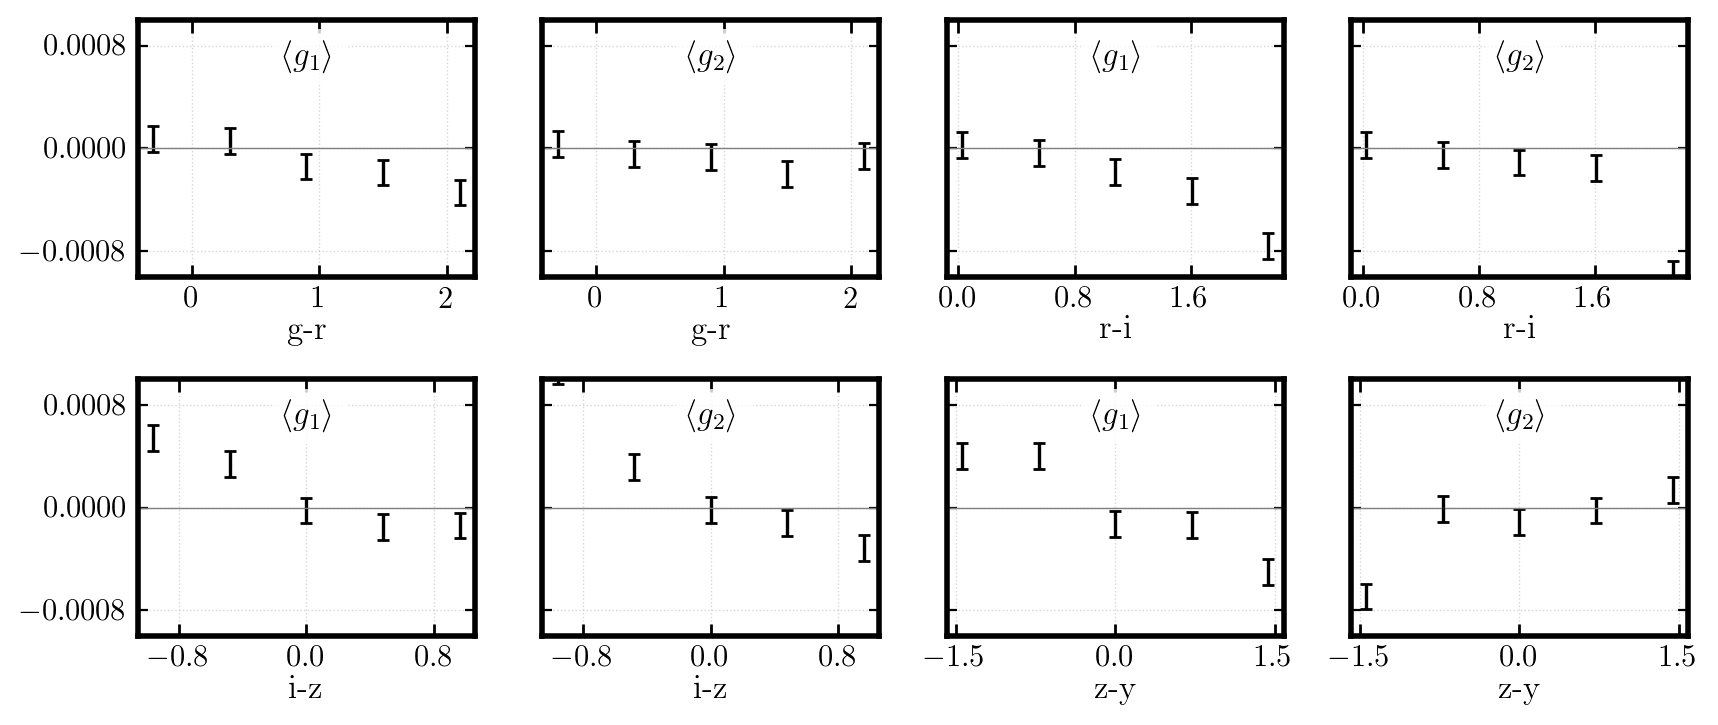

In [62]:
from matplotlib.ticker import MaxNLocator

# Create x, y, yerr for all 8 plots
x_data = []
y_data = []
y_errs = []

for arr in [gr, ri, iz, zy]:
    x = arr[0] / 5
    y1 = arr[1] / arr[2]
    y2 = arr[3] / arr[4]
    err1 = np.full_like(y1, 0.0001)  # Placeholder for yerr
    err2 = np.full_like(y2, 0.0001)

    x_data.extend([x, x])
    y_data.extend([y1, y2])
    y_errs.extend([err1, err2])

# Titles and labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = ["g-r", "g-r", "r-i","r-i", "i-z","i-z", "z-y", "z-y"]

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey=True, gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.001, 0.001)
    ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

In [65]:
msk = (mag_r - mag_i <  1.8) & (mag_i - mag_z > -0.8) & (mag_z - mag_y > -1.3)

In [66]:
np.sum(msk) / len(msk)

0.8422373868278806